## Task 1

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import scipy.signal


def harmonizeData(period):
    data = pd.read_csv('campusDemand.csv', infer_datetime_format=True)
    bdata = data.loc[data['Point name'] == 'Baker Hall Electric (Shark 29) - Demand Watts ']
    
    tdata = pd.read_csv('temperature.csv', infer_datetime_format=True)
    
    bdata = pd.DataFrame(index = pd.to_datetime(bdata['Time']),
                        data = bdata['Value'].values, columns=['D'])
    bdata = bdata.resample(period).mean()
    
    tdata = pd.DataFrame(index = pd.to_datetime(tdata['Timestamp']),
                        data = tdata['IW.Weather.Kpit56.Csv.Temp'].values, columns=['T'])
    
    joined = pd.DataFrame.join(bdata,tdata).interpolate()
    
    #remove weekends:
    joined = joined.loc[joined.index.dayofweek<5]
    
    return joined


joined = harmonizeData('15Min')

## Task 2

In [10]:
def createDesignMatrix1(df):
    
    def temp_vec(temp):
        out = []
        min_temp = -10
        temp -= min_temp
        for i in range(10):
            out.append(10 if temp >= 10 else temp)
            temp -= 10
            if temp < 0:
                temp = 0
        return out
        
    def identifier(timestamp):
        tofd = timestamp.time()
        dofw = timestamp.dayofweek
        return tofd.__str__()+'-'+dofw.__str__()

    unique_ids = 0
    indices = {}
    
    one_hot = []
    temp_vecs = []
    y = []
    
    for i in range(len(df)):
        ts = df.index[i]
        idx = identifier(ts)
        
        if not idx in indices:
            indices[idx] = unique_ids
            unique_ids += 1
            
        one_hot.append(indices[idx])
        temp_vecs.append(temp_vec(df.iloc[i]['T']))
        y.append(df.iloc[i]['D'])
        
    time_vecs = []
    for idx in one_hot:
        o = np.zeros((unique_ids,))
        o[idx]= 1
        time_vecs.append(o)
    
    A = np.concatenate([np.array(temp_vecs), np.array(time_vecs)], axis=1)
    y = np.array(y)
        
    return A,y

## Task 3

In [11]:
A1,y = createDesignMatrix1(joined)
coeffs1 = np.dot(np.linalg.pinv(A1),y)
y_hat1 = np.dot(A1,coeffs1)

## Task 4
I am investigating whether or not the 15min intervals are independent of the day.
Thus instead of having a feature for every combination of day and 15min interval, i.e. 480 features ($5days * 24\ hrs * 4 intervals\ per\ hour$), I seperate the two feature and thus have 101 features ($5days + 24\ hrs * 4 intervals\ per\ hour$).

In [12]:
def createDesignMatrix2(df):
    
    def temp_vec(temp):
        out = []
        min_temp = -10
        temp -= min_temp
        for i in range(10):
            out.append(10 if temp >= 10 else temp)
            temp -= 10
            if temp < 0:
                temp = 0
        return out
        
    def identifier(timestamp):
        tofd = timestamp.time()
        dofw = timestamp.dayofweek
        return tofd.__str__(), dofw.__str__()

    unique_ids1 = 0
    unique_ids2 = 0
    indices1 = {}
    indices2 = {}
    one_hot1 = []
    one_hot2 = []
    
    temp_vecs = []
    y = []
    
    for i in range(len(df)):
        ts = df.index[i]
        idx1, idx2 = identifier(ts)
        
        if not idx1 in indices1:
            indices1[idx1] = unique_ids1
            unique_ids1 += 1
        one_hot1.append(indices1[idx1])
        
        if not idx2 in indices2:
            indices2[idx2] = unique_ids2
            unique_ids2 += 1
        one_hot2.append(indices2[idx2])
        
        temp_vecs.append(temp_vec(df.iloc[i]['T']))
        y.append(df.iloc[i]['D'])
        
    time_vecs1 = []
    for idx1 in one_hot1:
        o = np.zeros((unique_ids1,))
        o[idx1]= 1
        time_vecs1.append(o)
        
    time_vecs2 = []
    for idx2 in one_hot2:
        o = np.zeros((unique_ids2,))
        o[idx2]= 1
        time_vecs2.append(o)
    
    A = np.concatenate([np.array(temp_vecs), np.array(time_vecs1), np.array(time_vecs2)], axis=1)
    y = np.array(y)
        
    return A,y

A2,y = createDesignMatrix2(joined)
coeffs2 = np.dot(np.linalg.pinv(A2),y)
y_hat2 = np.dot(A2,coeffs2)

## Task 5

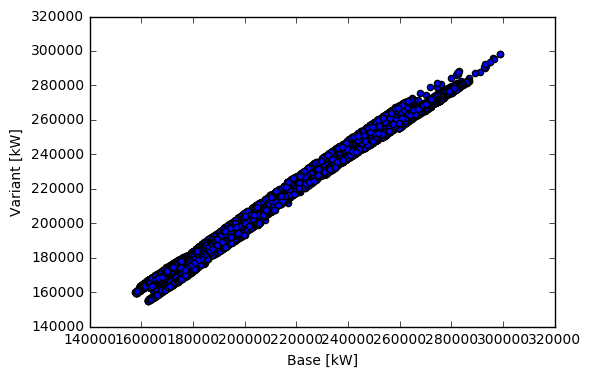

In [13]:
plt.figure()
plt.scatter(y_hat1, y_hat2)
plt.xlabel('Base [kW]')
plt.ylabel('Variant [kW]')

## Task 6

{'boxes': [<matplotlib.lines.Line2D at 0x11895a320>,
 'caps': [<matplotlib.lines.Line2D at 0x11a963ef0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a94e3c8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11b94d710>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11895a438>,
  <matplotlib.lines.Line2D at 0x11b915588>]}

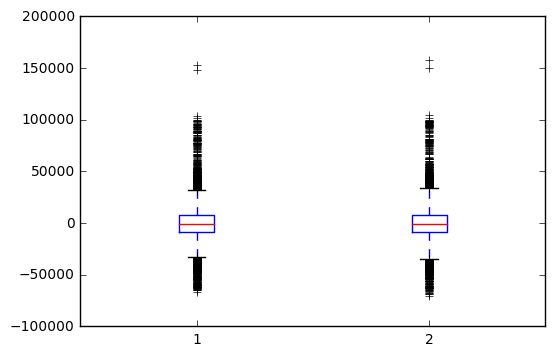

In [14]:
plt.figure()
plt.boxplot([(y_hat1-y), (y_hat2-y)])

## Task 7

I am using Budeanu's definition of reactive power.

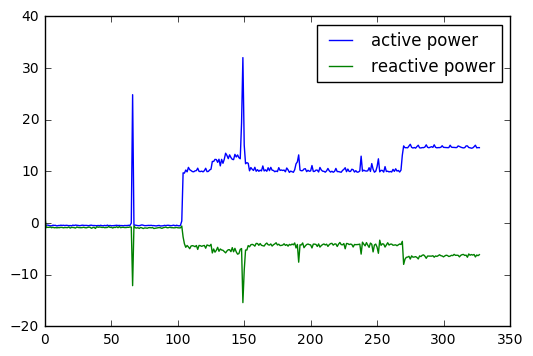

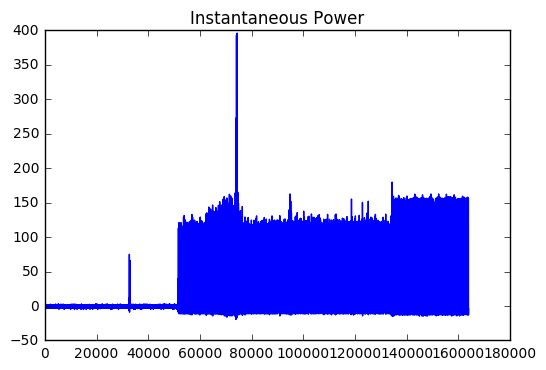

In [15]:
def computePQ(cur, volt):
    low = 0
    #smoothing voltage for zero-crossing detection
    volt = scipy.signal.convolve(volt, np.ones((5,))/5)[2:-2]
    powers = []
    for i in range(len(volt)-1):
        if volt[i]<0 and volt[i+1]>=0:
            power = cur[low:i]*volt[low:i]
            power_in = np.zeros((500,))
            l = np.min([len(power),500])
            power_in[:l] = power[:l]
            powers.append(power_in)
            low=i
    o = np.fft.fft(powers)
    plt.figure()
    plt.plot(np.mean(np.real(o[:,:250]),axis=1), label='active power')
    plt.plot(np.mean(np.imag(o[:,:250]),axis=1), label='reactive power')
    plt.legend()
    plt.figure()
    plt.title('Instantaneous Power')
    plt.plot(cur*volt)
    
data = np.loadtxt('116.csv', delimiter=',')
computePQ(data[:,0],data[:,1])